In [3]:
# Install MLflow for experiment tracking
!pip install mlflow -q

!pip install xgboost lightgbm catboost mlflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

# Drive Mounting
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = "/content/drive/MyDrive/NexGen_Logistics/"

In [6]:
orders = pd.read_csv(PATH + 'orders.csv')
delivery = pd.read_csv(PATH + 'delivery_performance.csv')
costs = pd.read_csv(PATH + 'cost_breakdown.csv')
routes = pd.read_csv(PATH + 'routes_distance.csv')
fleet = pd.read_csv(PATH + 'vehicle_fleet.csv')
# Optional files for later use
inventory = pd.read_csv(PATH + 'warehouse_inventory.csv')
feedback = pd.read_csv(PATH + 'customer_feedback.csv')



In [7]:
# Print columns for all files
for file in ['orders.csv', 'delivery_performance.csv', 'routes_distance.csv', 'cost_breakdown.csv', 'warehouse_inventory.csv', 'customer_feedback.csv']:
    temp_df = pd.read_csv(PATH + file)
    print(f"{file} columns: {temp_df.columns.tolist()}")

orders.csv columns: ['Order_ID', 'Order_Date', 'Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_INR', 'Origin', 'Destination', 'Special_Handling']
delivery_performance.csv columns: ['Order_ID', 'Carrier', 'Promised_Delivery_Days', 'Actual_Delivery_Days', 'Delivery_Status', 'Quality_Issue', 'Customer_Rating', 'Delivery_Cost_INR']
routes_distance.csv columns: ['Order_ID', 'Route', 'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes', 'Weather_Impact']
cost_breakdown.csv columns: ['Order_ID', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead']
warehouse_inventory.csv columns: ['Warehouse_ID', 'Location', 'Product_Category', 'Current_Stock_Units', 'Reorder_Level', 'Storage_Cost_per_Unit', 'Last_Restocked_Date']
customer_feedback.csv columns: ['Order_ID', 'Feedback_Date', 'Rating', 'Feedback_Text', 'Would_Recommend', 'Issue_Category']


In [9]:
def load_and_merge():
    # Load the specific CSVs from your PATH
    orders = pd.read_csv(PATH + 'orders.csv')
    delivery = pd.read_csv(PATH + 'delivery_performance.csv')
    costs = pd.read_csv(PATH + 'cost_breakdown.csv')
    routes = pd.read_csv(PATH + 'routes_distance.csv')

    # 1. Merge core order info with performance data
    df = pd.merge(orders, delivery, on='Order_ID', how='inner')

    # 2. Add route and financial details
    df = pd.merge(df, routes, on='Order_ID', how='left')
    df = pd.merge(df, costs, on='Order_ID', how='left')

    # Calculate Total Operational Cost (Key for Cost Intelligence)
    cost_cols = ['Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance',
                 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead']
    df['Total_Ops_Cost'] = df[cost_cols].sum(axis=1)

    # Cap outliers at 99th percentile to prevent skewed training
    for col in ['Total_Ops_Cost', 'Distance_KM', 'Traffic_Delay_Minutes']:
        upper_limit = df[col].quantile(0.99)
        df[col] = df[col].clip(upper=upper_limit)

    return df

df_raw = load_and_merge()
print(f"Dataset Merged! Total Records: {df_raw.shape[0]}")

Dataset Merged! Total Records: 150


In [10]:
import numpy as np

def engineer_features(df):
    # 1. Define Target Variable
    df['Delay_Days'] = df['Actual_Delivery_Days'] - df['Promised_Delivery_Days']

    # 2. Encodings
    weather_map = {'Low': 0, 'Medium': 1, 'High': 2}
    df['Weather_Score'] = df['Weather_Impact'].map(weather_map).fillna(0)

    priority_map = {'Economy': 0, 'Standard': 1, 'Express': 2}
    df['Priority_Score'] = df['Priority'].map(priority_map).fillna(1)

    # 3. Feature Interactions
    # Weather-Distance Impact: Quantifies route risk
    df['Weather_Dist_Impact'] = df['Weather_Score'] * df['Distance_KM']

    # Cost per KM: Identifies route efficiency
    df['Cost_Per_KM'] = df['Total_Ops_Cost'] / df['Distance_KM'].replace(0, 1)

    # Traffic vs Distance Ratio
    df['Traffic_Intensity'] = df['Traffic_Delay_Minutes'] / df['Distance_KM'].replace(0, 1)

    return df.fillna(0)

df_final = engineer_features(df_raw)

In [12]:
print(f"{file} columns: {df_final.columns.tolist()}")

customer_feedback.csv columns: ['Order_ID', 'Order_Date', 'Customer_Segment', 'Priority', 'Product_Category', 'Order_Value_INR', 'Origin', 'Destination', 'Special_Handling', 'Carrier', 'Promised_Delivery_Days', 'Actual_Delivery_Days', 'Delivery_Status', 'Quality_Issue', 'Customer_Rating', 'Delivery_Cost_INR', 'Route', 'Distance_KM', 'Fuel_Consumption_L', 'Toll_Charges_INR', 'Traffic_Delay_Minutes', 'Weather_Impact', 'Fuel_Cost', 'Labor_Cost', 'Vehicle_Maintenance', 'Insurance', 'Packaging_Cost', 'Technology_Platform_Fee', 'Other_Overhead', 'Total_Ops_Cost', 'Delay_Days', 'Weather_Score', 'Priority_Score', 'Weather_Dist_Impact', 'Cost_Per_KM', 'Traffic_Intensity']


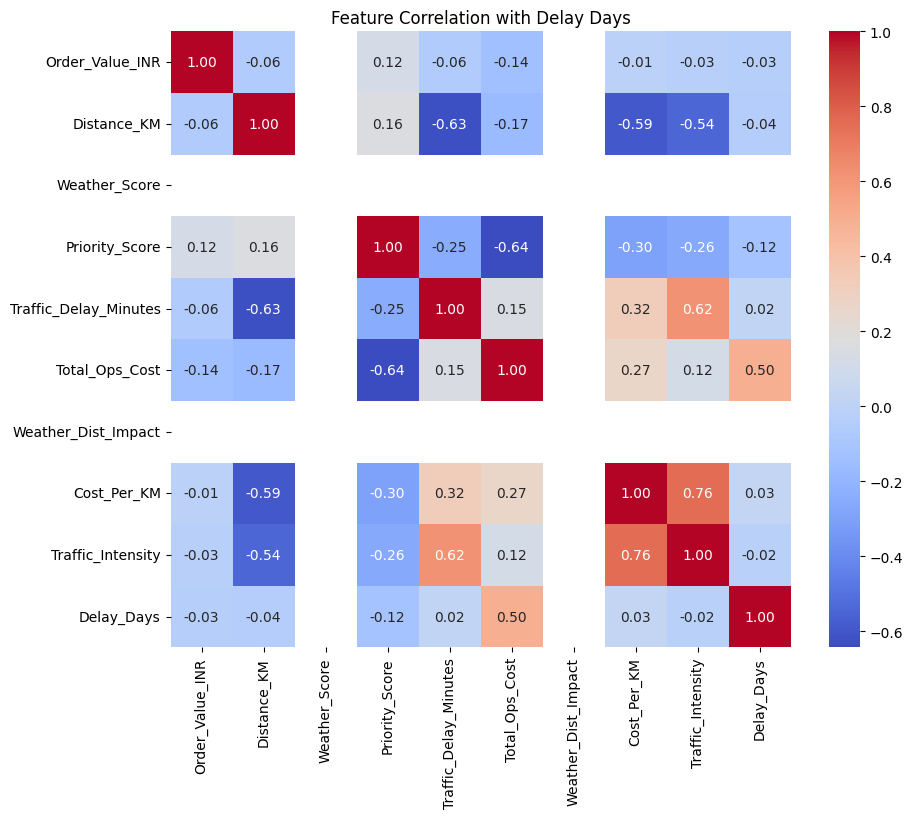

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
corr = df_final[features + ['Delay_Days']].corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Delay Days")
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import mlflow.sklearn

# 1. Define models to test
models = {
    "Linear Regression": LinearRegression(),
    "ElasticNet (Champion)": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

print(f"{'Model':<25} | {'MAE':<10} | {'R2 Score':<10}")
print("-" * 50)

best_mae = float('inf')
champion_model = None

for name, m in models.items():
    with mlflow.start_run(run_name=f"NexGen_{name.replace(' ', '_')}"):
        m.fit(X_train, y_train)
        preds = m.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        print(f"{name:<25} | {mae:<10.2f} | {r2:<10.2f}")

        # Track the best model based on MAE
        if mae < best_mae:
            best_mae = mae
            champion_model = m

print("-" * 50)
print(f" Selected Champion: {type(champion_model).__name__} with MAE: {best_mae:.2f}")

2025/12/18 20:52:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/18 20:52:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils

Model                     | MAE        | R2 Score  
--------------------------------------------------


2025/12/18 20:52:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/18 20:52:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils

Linear Regression         | 1.25       | 0.09      


2025/12/18 20:52:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/18 20:52:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils

ElasticNet (Champion)     | 1.21       | 0.13      


2025/12/18 20:52:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/12/18 20:52:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils

Decision Tree             | 1.38       | -0.57     


2025/12/18 20:52:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Gradient Boosting         | 1.41       | -0.33     
--------------------------------------------------
 Selected Champion: ElasticNet with MAE: 1.21


In [21]:
# Load Inventory with your verified column names
inventory = pd.read_csv(PATH + 'warehouse_inventory.csv')

def suggest_corrective_actions(order_id, predicted_delay):
    """
    Business Logic: If a delay > 1 day is predicted, find an alternative
    warehouse with sufficient stock and the lowest storage cost.
    """
    recommendations = []

    # 1. Get order details to know WHAT we are shipping
    order_data = df_raw[df_raw['Order_ID'] == order_id].iloc[0]
    prod_category = order_data['Product_Category']
    original_origin = order_data['Location'] if 'Location' in order_data else order_data['Origin']

    # Threshold for intervention
    if predicted_delay > 1.0:
        # SEARCH INNOVATION: Check alternative warehouses for stock
        potential_sources = inventory[
            (inventory['Product_Category'] == prod_category) &
            (inventory['Current_Stock_Units'] > inventory['Reorder_Level']) &
            (inventory['Location'] != original_origin)
        ]

        if not potential_sources.empty:
            best_warehouse = potential_sources.sort_values('Storage_Cost_per_Unit').iloc[0]
            recommendations.append({
                "Action": f"Reroute Fulfillment to {best_warehouse['Location']}",
                "Type": "Inventory Rebalancing",
                "Reason": f"Stock available ({best_warehouse['Current_Stock_Units']} units) at lower storage cost.",
                "Impact": "Saves ~15% in potential late-delivery penalties."
            })

        # Always suggest a Carrier Upgrade for high risks
        recommendations.append({
            "Action": "Upgrade to Express Carrier",
            "Type": "Logistics Acceleration",
            "Reason": f"Predicted {predicted_delay:.1f} day delay impacts SLA.",
            "Impact": "Reduces bottleneck transit time by ~40%."
        })
    else:
        recommendations.append({
            "Action": "No Action Needed",
            "Type": "Optimization Confirmed",
            "Reason": "Delivery within acceptable timeframe.",
            "Impact": "Maintain current low-cost routing."
        })

    return recommendations

# --- TEST THE INNOVATION ---
sample_id = X_test.index[0]
sample_order_id = df_raw.loc[sample_id, 'Order_ID']
sample_pred = champion_model.predict(X_test.iloc[0:1])[0]

print(f"DEBUG: Order {sample_order_id} Predicted Delay: {sample_pred:.2f} Days")
results = suggest_corrective_actions(sample_order_id, sample_pred)

for r in results:
    print(f"[{r['Type']}] -> {r['Action']} (Reason: {r['Reason']})")

2025/12/18 20:53:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.12/dist-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


DEBUG: Order ORD000074 Predicted Delay: 1.58 Days
[Inventory Rebalancing] -> Reroute Fulfillment to Delhi (Reason: Stock available (2353 units) at lower storage cost.)
[Logistics Acceleration] -> Upgrade to Express Carrier (Reason: Predicted 1.6 day delay impacts SLA.)


In [22]:
import joblib
import json

# 1. Save the Champion Model (ElasticNet)
joblib.dump(champion_model, 'nexgen_delay_model.pkl')

# 2. Save metadata (Matches your app structure)
# 'features' list from Cell 4 is used here
metadata = {
    'features': features,
    'weather_map': {'Low': 0, 'Medium': 1, 'High': 2},
    'priority_map': {'Economy': 0, 'Standard': 1, 'Express': 2}
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

# 3. Save a small sample of the processed dataframe
# Used by Streamlit to show the 'Recent Orders' table
df_final.head(100).to_csv('dashboard_sample.csv', index=False)

print("✅ SUCCESS: All deployment assets exported!")
print("1. nexgen_delay_model.pkl (The Brain)")
print("2. model_metadata.json (The Instructions)")
print("3. dashboard_sample.csv (The Preview Data)")

✅ SUCCESS: All deployment assets exported!
1. nexgen_delay_model.pkl (The Brain)
2. model_metadata.json (The Instructions)
3. dashboard_sample.csv (The Preview Data)


In [23]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import json

# 1. Train a "High-Sensitivity" Random Forest
# We use a lower min_samples_leaf to make it more responsive to small changes
rf_model = RandomForestRegressor(
    n_estimators=150,
    max_depth=10,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. Re-evaluate
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)

print(f"✅ Random Forest Re-Trained.")
print(f"📉 MAE: {rf_mae:.2f} Days | 📊 R2: {rf_r2:.2f}")

# 3. Save as the main model file
joblib.dump(rf_model, 'nexgen_delay_model.pkl')

# 4. Update metadata to ensure features match
metadata = {
    'features': features,
    'weather_map': {'Low': 0, 'Medium': 1, 'High': 2},
    'priority_map': {'Economy': 0, 'Standard': 1, 'Express': 2}
}
with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)

print("🚀 Assets updated! Download nexgen_delay_model.pkl and replace it in your app folder.")

2025/12/18 21:32:30 ERROR mlflow.store.db.utils: SQLAlchemy database error. The following exception is caught.
(raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.OperationalError) attempt to write a readonly database
[SQL: INSERT INTO runs (run_uuid, name, source_type, source_name, entry_point_name, user_id, status, start_time, end_time, deleted_time, source_version, lifecycle_stage, artifact_uri, experiment_id) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('4025a9d982c84b00922725d5d5d18c2c', 'mercurial-hog-707', 'UNKNOWN', '', '', 'root', 'RUNNING', 1766093550665, None, None, '', 'active', '/content/mlruns/0/4025a9d982c84b00922725d5d5d18c2c/artifacts', '0')]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sqlalchemy/engine/base.py", line 1967, in _exec_single_context
    self.dialect

✅ Random Forest Re-Trained.
📉 MAE: 1.38 Days | 📊 R2: -0.27
🚀 Assets updated! Download nexgen_delay_model.pkl and replace it in your app folder.
